# **Generative Adversarial Networks (GANs) in PyTorch** 

![GEnerator and descriminator](GeneratorAndDescriminator.png)
![GEnerator and descriminator](BasicArchitectureGan.png)
![GEnerator and descriminator](generative_adversarial_networks_formula.png)


In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(42)

cuda


## **Fetch our MNIST Dataset using torchvision and Create our transforms and Data Loader**

In [2]:
batch_size = 32

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
                               
train_set = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 9332555.00it/s] 


Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 302403.77it/s]


Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 2002285.29it/s]


Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4394585.64it/s]

Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



### **Now let's plot some of our original (real) data**

1 1 2 4 9 7 9 1 9 4 7 4 7 7 1 5 6 4 1 4 1 0 4 7 5 4 4 2 5 8 6 9 

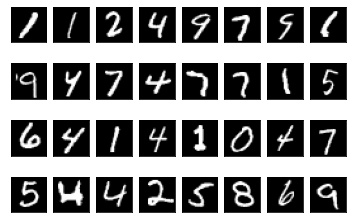

In [7]:
samples, labels = next(iter(train_loader))

for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow(samples[i].reshape(28, 28), cmap="gray")
    print(labels[i].item(), end=" ")
    plt.xticks([])
    plt.yticks([])

## **Define our Discriminator Model**

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            # We don't use Conv layers here but we vectorize our inputs
            nn.Linear(784, 2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1), # We output a single scalar value
            nn.Sigmoid(), #we use a sigmoid activation function to squash the output to a 0-1 range
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output #Our output shows how confident the model is that the input image is real . A value close to 1 means the model is confident the image is real, while a value close to 0 means the model is confident the image is fake.

# We instantiate our mode and send it to the GPU
discriminator = Discriminator().to(device=device)

## **Define our Generator Model**

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(), # We use the Tanh() activation fucntion so that our outputs lie between -1 and 1
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28) # We reshape the output to be the same shape as the real images  into the format [batch_size, 1, 28, 28]
        return output

# We instantiate our mode and send it to the GPU
generator = Generator().to(device=device)

## **Set our training parameters**

In [10]:
# Set our learning rate, epochs
lr = 0.0001
epochs = 50
loss_function = nn.BCELoss() # We use the **Binary Cross Entropy** loss function as we are performing binary classification. The formula for BCE is: -[y * log(x) + (1 - y) * log(1 - x)] where y is the target value and x is the predicted value.

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [11]:
for epoch in range(epochs):
    for n, (samples, labels) in enumerate(train_loader):
        # Get data for training the discriminator
        real_samples = samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device) # We label the real images as 1 and that 1 in parantheses means that we are creating a tensor of ones with the shape (batch_size, 1) that means for each sample in the batch we have one column of ones.
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels) # We compare that we real numbers bcz we want the generator to generate images that are as close to real as possible and fool the discriminator
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == len(train_loader) - 1: # because len(train_loader) is the number of batches in the dataset and -1 bcz it starts from 0
            print(f"Epoch: {epoch} Descrimianted Loss: {loss_discriminator}")
            print(f"Epoch: {epoch} Generator Loss: {loss_generator}")

Epoch: 0 Descrimianted Loss: 0.004107417073100805
Epoch: 0 Generator Loss: 7.258843421936035
Epoch: 1 Descrimianted Loss: 0.019170019775629044
Epoch: 1 Generator Loss: 5.77542781829834
Epoch: 2 Descrimianted Loss: 0.0009413777734152973
Epoch: 2 Generator Loss: 7.6972527503967285
Epoch: 3 Descrimianted Loss: 0.006913759745657444
Epoch: 3 Generator Loss: 6.7889018058776855
Epoch: 4 Descrimianted Loss: 0.011418692767620087
Epoch: 4 Generator Loss: 6.924615383148193
Epoch: 5 Descrimianted Loss: 0.018754227086901665
Epoch: 5 Generator Loss: 6.420057773590088
Epoch: 6 Descrimianted Loss: 0.012266065925359726
Epoch: 6 Generator Loss: 5.207097053527832
Epoch: 7 Descrimianted Loss: 0.15484902262687683
Epoch: 7 Generator Loss: 3.7824039459228516
Epoch: 8 Descrimianted Loss: 0.1114731878042221
Epoch: 8 Generator Loss: 2.824282646179199
Epoch: 9 Descrimianted Loss: 0.15843111276626587
Epoch: 9 Generator Loss: 2.299039840698242
Epoch: 10 Descrimianted Loss: 0.1757374405860901
Epoch: 10 Generator Lo

## **Now let's Inspect our Generated Samples**

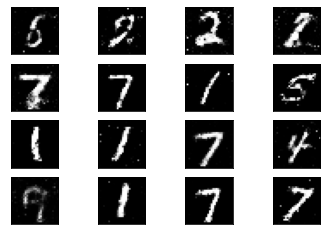

In [13]:
generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray")
    plt.xticks([])
    plt.yticks([])